In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.matcher import FlannMatcher

from autocnet.matcher import subpixel as sp 
from scipy.misc import imresize
import math
import warnings
import cv2


from bisect import bisect

from scipy.ndimage.interpolation import rotate

from IPython.display import display
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Create Basic Structures

In [2]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match_features()

# Perform the symmetry check
cg.symmetry_checks()
# Perform the ratio check
cg.ratio_checks(clean_keys = ['symmetry'])
# Create fundamental matrix
cg.compute_fundamental_matrices(clean_keys = ['symmetry', 'ratio'])


# Step: Compute the homographies and apply RANSAC
cg.compute_homographies(clean_keys=['symmetry', 'ratio'])

# Step: Compute the overlap ratio and coverage ratio
for s, d, edge in cg.edges_iter(data=True):
    edge.coverage_ratio(clean_keys=['symmetry', 'ratio'])

# Step: Compute subpixel offsets for candidate points
cg.subpixel_register(clean_keys=['ransac'])

cg.suppress(clean_keys=['symmetry', 'ratio', 'subpixel'])

# Define Stuff

In [28]:
from copy import deepcopy

def to_polar_coord(shape, center):
    y,x = np.ogrid[:shape[0],:shape[1]]
    cy,cx = center
    tmin,tmax = (0,2*math.pi)

    # ensure stop angle > start angle
    if tmax < tmin:
        tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)
    
    return r2, theta

def circ_mask(shape,center,radius):
    r, theta = to_polar_coord(shape, center)
    
    circmask = r == radius*radius
    anglemask = theta <= 2*math.pi
        
    return circmask*anglemask

def radial_line_mask(shape, center, radius, alpha=0.19460421, atol=.01):
    r, theta = to_polar_coord(shape, center)
    
    line_mask = r <= radius**2
    anglemask = numpy.isclose(theta, alpha, atol=atol)
        
    return line_mask*anglemask
    
    
def ciratefi(template, search_image, upsampling=1, t1=.75, t2=.75,  alpha=math.pi/16,
             scales=[0.5, 0.57, 0.66,  0.76, 0.87, 1.0], radii=list(range(1,12))):
    '''
        Run the cirateft algorithm given the input template and target image along
        with scales and Radii. 
    '''
    # check the paramter domains
    if upsampling < 1:
        raise ValueError
    
    # check for upsampling
    if upsampling > 1:
        template = zoom(template, upsampling, order=1)
        search_image = zoom(search_image, upsampling, order=1)
    
    
    # Cifi -- Circular Sample on Template
    template_result = np.empty((len(scales), len(radii)))
    
    for i, s in enumerate(scales):
        scaled_img = imresize(template, s)
        for j, r in enumerate(radii):
            # Generate a circular mask
            a, b = (int(scaled_img.shape[0] / 2),
                    int(scaled_img.shape[1] / 2))
            
            if r > b or r > a:
                s =-1
            
            mask = circ_mask(scaled_img.shape, (a,b), r)
            
            inv_area = 1 / (2 * math.pi * r)
            s = np.sum(scaled_img[mask]) * inv_area
            
            if s == 0:
                s = -1
            template_result[i,j] = s
    
    # Cifi2 -- Circular Sample on Target Image
    search_result = np.empty((search_image.shape[0], search_image.shape[1], len(radii)))
    
    for i, y in enumerate(range(search_image.shape[0])):
        for j, x in enumerate(range(search_image.shape[1])):
            for k, r in enumerate(radii):
                inv_area = 1 / (2 * math.pi * r)
                
                mask = circ_mask(search_image.shape, (i,j), r)
                
                s = np.sum(search_image[mask]) * inv_area
                
                if s == 0:
                    s = -1
                search_result[i, j, k] = s
    
    # Perform Normalized Cross-Correlation between template and target image
    coeffs = np.empty((search_result.shape[0], search_result.shape[1]))
    best_scales = np.empty((search_result.shape[0], search_result.shape[1]))
    
    for y, l in enumerate(range(search_result.shape[0])):
        for x, m in enumerate(range(search_result.shape[1])):
            for i, k in enumerate(range(template_result.shape[0])):
                maxcoeff = -math.inf
                maxscale = -math.inf
                
                coeff = np.corrcoef(template_result[i], search_result[y,x])[0,1]
                
                if coeff > maxcoeff:
                    maxcoeff = coeff
                    maxscale = i
        
            coeffs[y,x] = maxcoeff
            best_scales[y,x] = scales[maxscale]
    
    pylab.imshow(coeffs, interpolation='none')
    pylab.show()
    
    # get first grade candidate points
    fg_candidate_points = [(y,x) for (y,x),coeff in np.ndenumerate(coeffs) if coeff>=t1]
    
    # Rafi 1  -- Get Radial Samples of Template Image
    alpha_list = np.arange(0, 2*pi, alpha)
    alpha_template_samples = np.zeros(len(alpha_list))
    center_y, center_x = (int(template.shape[0] / 2),
                          int(template.shape[1] / 2))
    
    # find the largest fitting radius
    rad_thresh = center_x if center_x <= center_y else center_y
    radius = radii[bisect(radii, rad_thresh)]

    for i in range(len(alpha_template_samples)):
        # Create Radial Line Mask
        mask = radial_line_mask(template.shape, (center_x, center_y), radius, alpha=alpha_list[i])
        
        # Sum the values
        alpha_template_samples[i] = np.sum(template[mask])/radius
        
    # Rafi 2 -- Get Radial Samples of the Search Image for all First Grade Candidate Points
    rafi_coeffs = np.zeros((len(fg_candidate_points), len(alpha_list)))
    
    for i in range(len(fg_candidate_points)):
        y, x = fg_candidate_points[i]
        
        # Scale image to the best fit scale
        scaled_img = imresize(search_image, best_scales[y,x])
        for j in range(len(alpha_list)):
            # Create Radial Mask
            mask = radial_line_mask(scaled_img.shape, (y, x), radius, alpha=alpha_list[j])
            rafi_coeffs[i][j] = np.sum(scaled_img[mask])/radius

    coeffs = np.zeros((search_result.shape[0], search_result.shape[1]))
    best_rotation = []
    sg_candidate_points = []
    
    # Perform Normalized Cross-Correlation between template and target image
    for i in range(len(fg_candidate_points)):
        for j in range(len(alpha_list)):
            rotated_template = rotate(template, alpha_list[j])
            y, x = fg_candidate_points[i]
            maxcoeff = -math.inf
            maxrotate = 0
            
            coeff = np.corrcoef(alpha_template_samples, rafi_coeffs[i])[0,1]
        
            if coeff > maxcoeff:
                maxcoeff = coeff
                maxrotate = j
        
        coeffs[y,x] = maxcoeff
        if(maxcoeff >= t2):
            best_rotation.append(alpha_list[maxrotate])
            sg_candidate_points.append((y,x))
            

    pylab.imshow(coeffs, interpolation='none')
    pylab.show()
    
    coeffs = np.zeros((search_result.shape[0], search_result.shape[1]))
    # sg_candidate_points = [(y,x) for (y,x),coeff in np.ndenumerate(coeffs) if coeff>=t2]
    tefi_coeffs = []
    
    # Tefi -- Template Matching Filter
    for i in range(len(sg_candidate_points)):
        maxcoeff = -math.inf
        y, x = sg_candidate_points[i]
        
        transformed_template = imresize(template, best_scales[y,x])
        transformed_template = rotate(transformed_template, best_rotation[i])
        y_window, x_window = (transformed_template.shape[0]/2,
                              transformed_template.shape[1]/2)
        
        if x < x_window or y < y_window:
            continue
        
        cropped_search_image = search_image[y-y_window:y+y_window, x-x_window:x+x_window]
        
        result = cv2.matchTemplate(cropped_search_image.astype(np.float32), transformed_template.astype(np.float32), method=cv2.TM_CCORR_NORMED)
        min_corr, max_corr, min_loc, max_loc = cv2.minMaxLoc(result)
        
        coeff = max_corr # np.corrcoef(transformed_template, cropped_search_image)[0,1]
        
        if coeff > maxcoeff:
            maxcoeff = coeff
            
        coeffs[y,x] = maxcoeff
        tefi_coeffs.append(maxcoeff)
        
    pylab.imshow(coeffs, interpolation='none')
    pylab.colorbar()
    
    print('Maximum Correlation @ ', sg_candidate_points[tefi_coeffs.index(max(tefi_coeffs))], ' with ', max(tefi_coeffs))
    

# Do Stuff

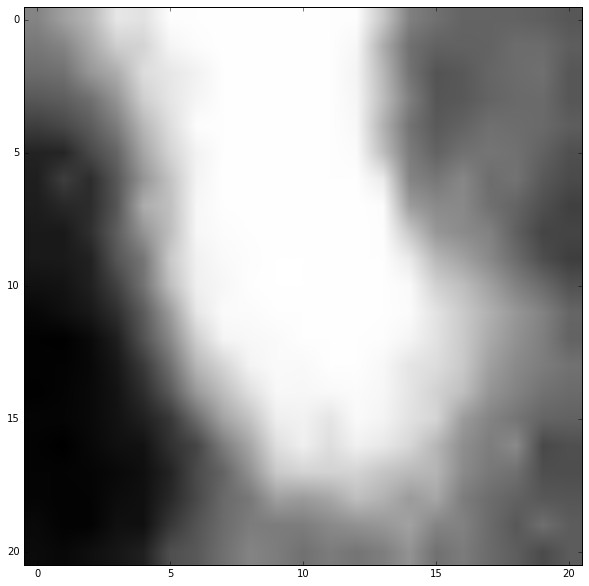

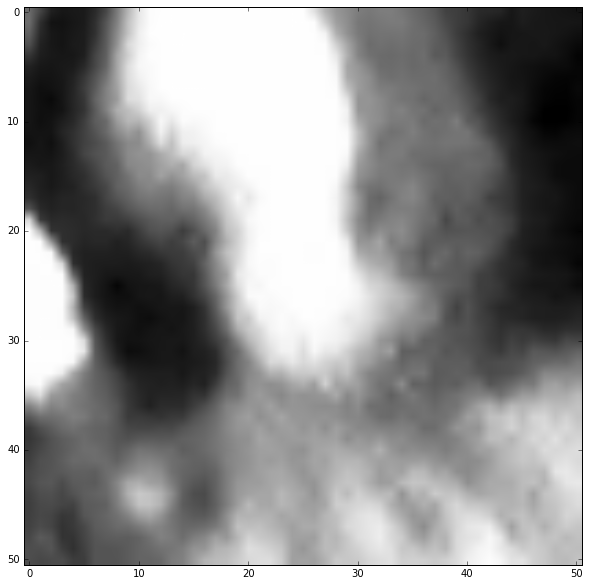

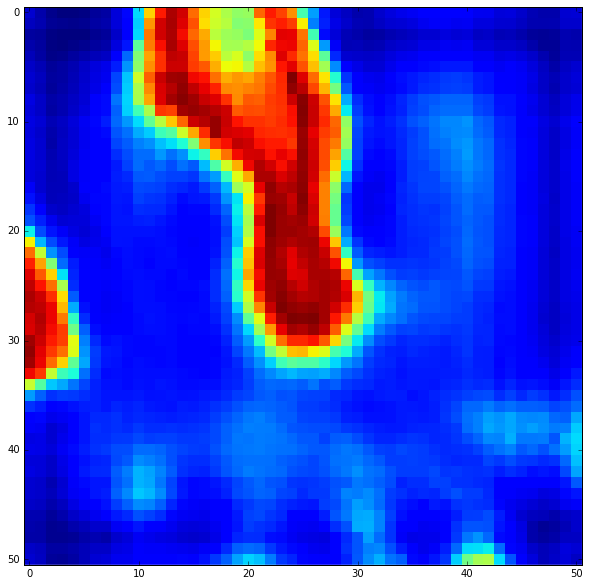

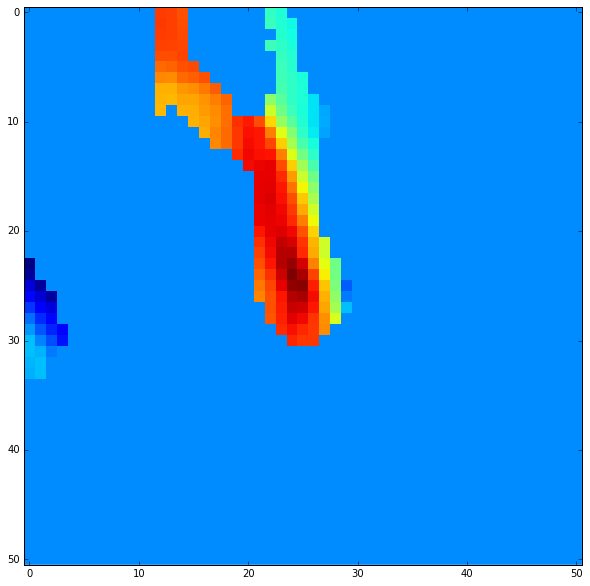

Maximum Correlation @  (24, 24)  with  0.7581686973571777


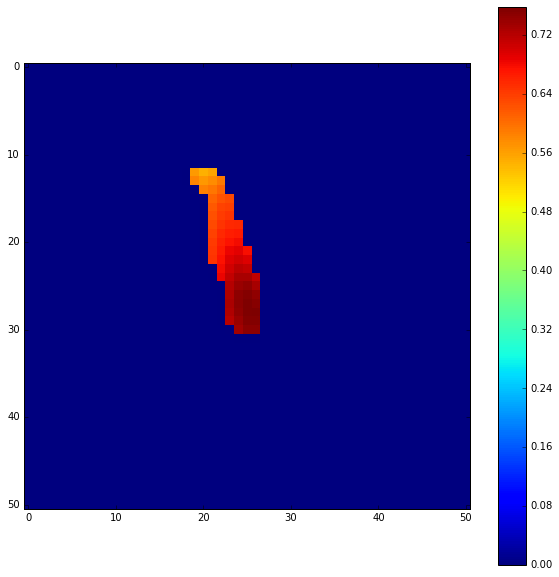

In [29]:
from scipy.ndimage.interpolation import zoom
from scipy.stats.stats import pearsonr 

figsize(10,10)
e = cg.edge[0][2]
matches = e.matches
clean_keys = ['subpixel']

full_offsets = np.zeros((len(matches), 3))

if clean_keys:
    matches, mask = e._clean(clean_keys)

# Preallocate the numpy array to avoid appending and type conversion
edge_offsets = np.empty((len(matches),3))

# for each edge, calculate this for each keypoint pair
for i, (idx, row) in enumerate(matches.iterrows()):
    s_idx = int(row['source_idx'])
    d_idx = int(row['destination_idx'])
    s_kps = e.source.get_keypoints().iloc[s_idx]
    d_kps = e.destination.get_keypoints().iloc[d_idx]

    s_keypoint = e.source.get_keypoints().iloc[s_idx][['x', 'y']].values
    d_keypoint = e.destination.get_keypoints().iloc[d_idx][['x', 'y']].values

    # Get the template and search windows
    s_template = sp.clip_roi(e.source.geodata, s_keypoint, 21)
    # s_template = rotate(s_template, 90)
    d_search = sp.clip_roi(e.destination.geodata, d_keypoint, 51)

    imshow(s_template, cmap='Greys')
    show()
    imshow(d_search, cmap='Greys')
    show()
    
    ciratefi(s_template, d_search, upsampling=1, alpha=math.pi/4, t1=.75)
    break